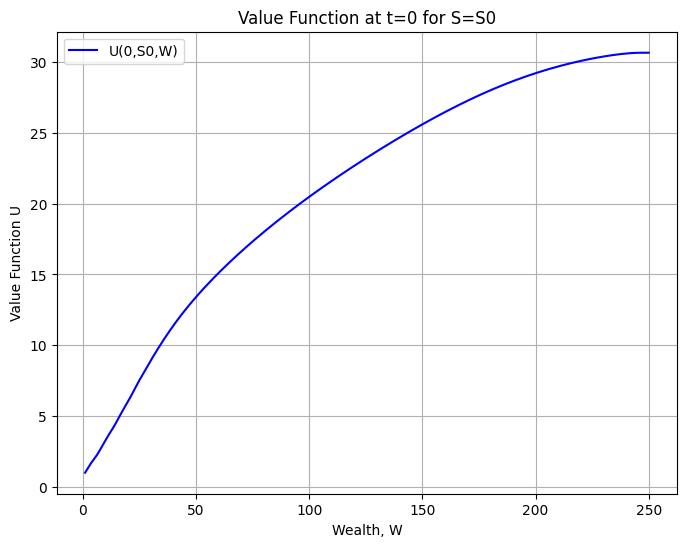

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Parameters
# ==============================

# Time parameters
T = 1.0                   # Terminal time
N_t = 20                  # Number of time steps (small for demonstration)
dt = T / N_t              # Time step size

# Stock process parameters
S0 = 100.0                # Initial stock price
sigma = 0.2               # Volatility
alpha = 0.03               # Drift of the stock
r = 0.03                  # Risk-free rate
K = 100.0                 # Strike of the call

# Utility parameters (CRRA utility)
gamma = 0.5               # CRRA parameter (0<gamma<1)

# Controls (discrete set for pi)
pi_vals = np.linspace(0, 1, 20)

# For the binomial tree for S:
u = np.exp(sigma * np.sqrt(dt))
d = np.exp(-sigma * np.sqrt(dt))
# Physical probability (using the drift alpha)
p = (np.exp(alpha * dt) - d) / (u - d)

# ==============================
# Wealth grid
# ==============================
W_min, W_max = 1.0, 250.0   # wealth boundaries
N_W = 200                   # number of wealth grid points
W_grid = np.linspace(W_min, W_max, N_W)

# ==============================
# Data structure for the value function
# ==============================
# We store U in a dictionary with keys (n, i) where:
#  - n is the time step (0,...,N_t)
#  - i is the node index for the stock price (i = number of up moves)
#
# At each node, U[n,i] is an array of length N_W corresponding to U(t_n, S_{n,i}, W) evaluated on the wealth grid.
U = {}
Pi = np.zeros((N_W,N_t),dtype=object)

# ==============================
# Terminal condition at time T
# ==============================
# At time N_t, for each node with i up moves, the stock price is:
# S = S0 * u^i * d^(N_t - i)
for i in range(N_t+1):
    S_val = S0 * (u**i) * (d**(N_t - i))
    U[(N_t, i)] = np.zeros(N_W)
    for j, W in enumerate(W_grid):
        payoff = max(S_val - K, 0.0)  # call payoff for the short position
        net_W = W - payoff
        # Avoid negative wealth (set a floor)
        net_W = max(net_W, 1e-8)
        U[(N_t, i)][j] = net_W**gamma / gamma

# ==============================
# Backward induction (Dynamic Programming)
# ==============================
# We work backward from n = N_t-1 down to n = 0.
# At each node (n, i) the stock price is S = S0 * u^i * d^(n-i)
# From node (n, i), an upward move goes to (n+1, i+1) and a downward move to (n+1, i).
# We interpolate the value function on the wealth grid.
def interp_value(W_new, W_grid, U_array):
    """Linear interpolation for U given wealth W_new on grid W_grid and value function U_array."""
    return np.interp(W_new, W_grid, U_array)

# Loop backward in time:
for n in reversed(range(N_t)):
    for i in range(n+1):  # node indices at time step n go from 0 to n
        S_val = S0 * (u**i) * (d**(n - i))
        U_val = np.zeros(N_W)  # to store U at node (n,i) on each wealth grid point
        # For each wealth level on the grid:
        for j, W in enumerate(W_grid):
            best_val = -1e12
            # Optimize over control pi:
            for pi in pi_vals:
                # Compute next wealth levels (using discrete-time approximation)
                # Up move:
                W_up = W * (1 + r*dt + pi*((alpha - r)*dt + sigma*np.sqrt(dt)))
                # Down move:
                W_down = W * (1 + r*dt + pi*((alpha - r)*dt - sigma*np.sqrt(dt)))
                # Obtain U at next nodes (n+1, i+1) for up move and (n+1, i) for down move.
                U_up = interp_value(W_up, W_grid, U[(n+1, i+1)])
                U_down = interp_value(W_down, W_grid, U[(n+1, i)])
                # Expected value at this node for this control:
                U_pi = p * U_up + (1-p) * U_down
                if U_pi > best_val:
                    best_val = U_pi
                    # (Optionally, record the optimal pi here)
                    Pi[j,n] = (W,n,pi)
            U_val[j] = best_val
        U[(n, i)] = U_val  # store the computed value function at node (n,i)

# ==============================
# Display / Plot the result
# ==============================
# For example, plot U(0,S0,W) vs. W at the root node (time 0, index 0).
plt.figure(figsize=(8,6))
plt.plot(W_grid, U[(0, 0)], 'b-', label="U(0,S0,W)")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import norm

# ------------------------------
# Black-Scholes Call Price Function
# ------------------------------
def call_price(t, S, T, r, sigma, K):
    tau = T - t
    if tau < 1e-8:
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r*tau) * norm.cdf(d2)

def Delta(t, S, T, r, sigma, K):
    tau = T-t 
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    return norm.cdf(d1)

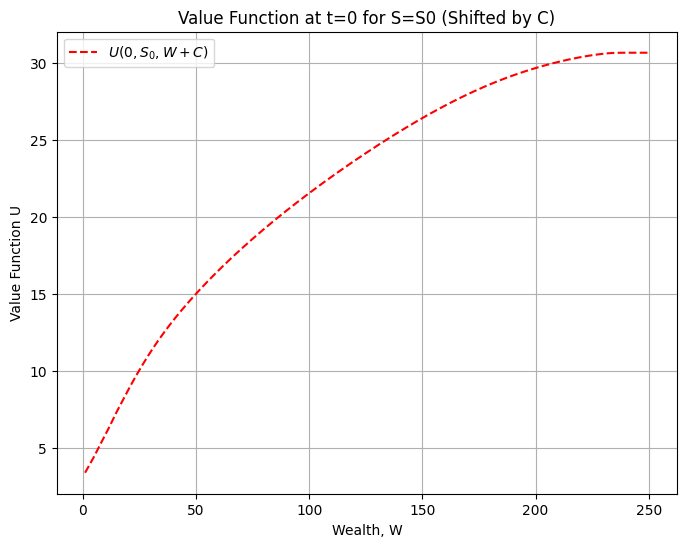

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Parameters
# ==============================

# Time parameters
T = 1.0                   # Terminal time
N_t = 20                  # Number of time steps (small for demonstration)
dt = T / N_t              # Time step size

# Stock process parameters
S0 = 100.0                # Initial stock price
sigma = 0.2               # Volatility
alpha = 0.03               # Drift of the stock
r = 0.03                  # Risk-free rate
K = 100.0                 # Strike of the call

# Utility parameters (CRRA utility)
gamma = 0.5               # CRRA parameter (0<gamma<1)

# Controls (discrete set for pi)
pi_vals = np.linspace(0, 1, 20)

# For the binomial tree for S:
u = np.exp(sigma * np.sqrt(dt))
d = np.exp(-sigma * np.sqrt(dt))
# Physical probability (using the drift alpha)
p = (np.exp(alpha * dt) - d) / (u - d)

# ==============================
# Wealth grid
# ==============================
W_min, W_max = 1.0, 250.0  # wealth boundaries
N_W = 200                  # number of wealth grid points
W_grid = np.linspace(W_min, W_max, N_W)

# ==============================
# Data structure for the value function
# ==============================
# We store U in a dictionary with keys (n, i) where:
#  - n is the time step (0,...,N_t)
#  - i is the node index for the stock price (i = number of up moves)
#
# At each node, U[n,i] is an array of length N_W corresponding to U(t_n, S_{n,i}, W) evaluated on the wealth grid.
U = {}
#Pi = np.zeros((N_W,N_t))

# ==============================
# Terminal condition at time T
# ==============================
# At time N_t, for each node with i up moves, the stock price is:
# S = S0 * u^i * d^(N_t - i)
for i in range(N_t+1):
    S_val = S0 * (u**i) * (d**(N_t - i))
    U[(N_t, i)] = np.zeros(N_W)
    for j, W in enumerate(W_grid):
        payoff = max(S_val - K, 0.0)  # call payoff for the short position
        net_W = W - payoff
        # Avoid negative wealth (set a floor)
        net_W = max(net_W, 1e-8)
        U[(N_t, i)][j] = net_W**gamma / gamma

# ==============================
# Backward induction (Dynamic Programming)
# ==============================
# We work backward from n = N_t-1 down to n = 0.
# At each node (n, i) the stock price is S = S0 * u^i * d^(n-i)
# From node (n, i), an upward move goes to (n+1, i+1) and a downward move to (n+1, i).
# We interpolate the value function on the wealth grid.
def interp_value(W_new, W_grid, U_array):
    """Linear interpolation for U given wealth W_new on grid W_grid and value function U_array."""
    return np.interp(W_new, W_grid, U_array)

# Loop backward in time:
for n in reversed(range(N_t)):
    for i in range(n+1):  # node indices at time step n go from 0 to n
        S_val = S0 * (u**i) * (d**(n - i))
        U_val = np.zeros(N_W)  # to store U at node (n,i) on each wealth grid point
        # For each wealth level on the grid:
        for j, W in enumerate(W_grid):
            best_val = -1e12
            # Optimize over control pi:
            for pi in pi_vals:
                # Compute next wealth levels (using discrete-time approximation)
                # Up move:
                W_up = W * (1 + r*dt + pi*((alpha - r)*dt + sigma*np.sqrt(dt)))
                # Down move:
                W_down = W * (1 + r*dt + pi*((alpha - r)*dt - sigma*np.sqrt(dt)))
                # Obtain U at next nodes (n+1, i+1) for up move and (n+1, i) for down move.
                U_up = interp_value(W_up, W_grid, U[(n+1, i+1)])
                U_down = interp_value(W_down, W_grid, U[(n+1, i)])
                # Expected value at this node for this control:
                U_pi = p * U_up + (1-p) * U_down
                if U_pi > best_val:
                    best_val = U_pi
                    # (Optionally, record the optimal pi here)
                    #Pi[j,n] = pi
            U_val[j] = best_val
        U[(n, i)] = U_val  # store the computed value function at node (n,i)

# Choose your constant C
C = call_price(0, S0, T, r, sigma, K)  # for instance

# Create a shifted wealth grid
W_shifted = W_grid + C

# Use linear interpolation to evaluate U(0,S0,W_shifted)
U_shifted = np.interp(W_shifted, W_grid, U[(0, 0)])

plt.figure(figsize=(8,6))
plt.plot(W_grid, U_shifted, 'r--', label=r"$U(0,S_0,W+C)$")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0 (Shifted by C)")
plt.legend()
plt.grid(True)
plt.show()


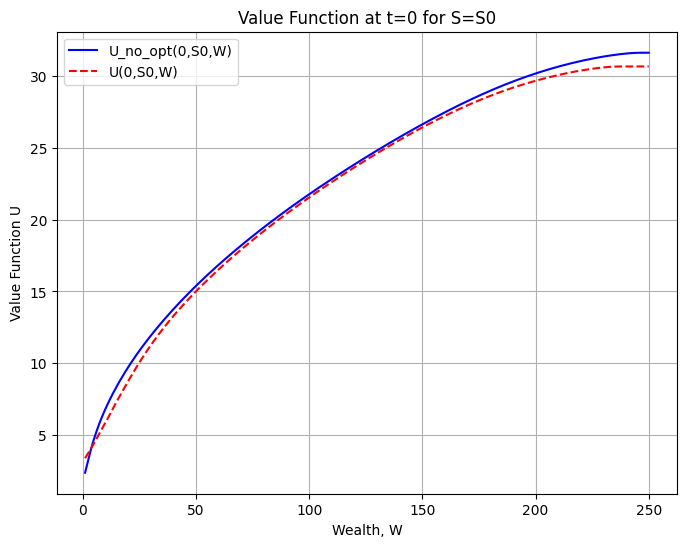

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Parameters
# ==============================

# Time parameters
T = 1.0                   # Terminal time
N_t = 20                  # Number of time steps (small for demonstration)
dt = T / N_t              # Time step size

# Stock process parameters
S0 = 100.0                # Initial stock price
sigma = 0.2               # Volatility
alpha = 0.03               # Drift of the stock
r = 0.03                  # Risk-free rate
K = 100.0                 # Strike of the call

# Utility parameters (CRRA utility)
gamma = 0.5               # CRRA parameter (0<gamma<1)

# Controls (discrete set for pi)
pi_vals = np.linspace(0, 1, 20)

# For the binomial tree for S:
u = np.exp(sigma * np.sqrt(dt))
d = np.exp(-sigma * np.sqrt(dt))
# Physical probability (using the drift alpha)
p = (np.exp(alpha * dt) - d) / (u - d)

# ==============================
# Wealth grid
# ==============================
W_min, W_max = 1.0, 250.0  # wealth boundaries
N_W = 200                   # number of wealth grid points
W_grid = np.linspace(W_min, W_max, N_W)

# ==============================
# Data structure for the value function
# ==============================
# We store U in a dictionary with keys (n, i) where:
#  - n is the time step (0,...,N_t)
#  - i is the node index for the stock price (i = number of up moves)
#
# At each node, U[n,i] is an array of length N_W corresponding to U(t_n, S_{n,i}, W) evaluated on the wealth grid.
U_no_opt = {}
#Pi = np.zeros((N_W,N_t))

# ==============================
# Terminal condition at time T
# ==============================
# At time N_t, for each node with i up moves, the stock price is:
# S = S0 * u^i * d^(N_t - i)
for i in range(N_t+1):
    S_val = S0 * (u**i) * (d**(N_t - i))
    U_no_opt[(N_t, i)] = np.zeros(N_W)
    for j, W in enumerate(W_grid):
        net_W = W
        # Avoid negative wealth (set a floor)
        net_W = max(net_W, 1e-8)
        U_no_opt[(N_t, i)][j] = net_W**gamma / gamma

# ==============================
# Backward induction (Dynamic Programming)
# ==============================
# We work backward from n = N_t-1 down to n = 0.
# At each node (n, i) the stock price is S = S0 * u^i * d^(n-i)
# From node (n, i), an upward move goes to (n+1, i+1) and a downward move to (n+1, i).
# We interpolate the value function on the wealth grid.
def interp_value(W_new, W_grid, U_array):
    """Linear interpolation for U given wealth W_new on grid W_grid and value function U_array."""
    return np.interp(W_new, W_grid, U_array)

# Loop backward in time:
for n in reversed(range(N_t)):
    for i in range(n+1):  # node indices at time step n go from 0 to n
        S_val = S0 * (u**i) * (d**(n - i))
        U_val = np.zeros(N_W)  # to store U at node (n,i) on each wealth grid point
        # For each wealth level on the grid:
        for j, W in enumerate(W_grid):
            best_val = -1e12
            # Optimize over control pi:
            for pi in pi_vals:
                # Compute next wealth levels (using discrete-time approximation)
                # Up move:
                W_up = W * (1 + r*dt + pi*((alpha - r)*dt + sigma*np.sqrt(dt)))
                # Down move:
                W_down = W * (1 + r*dt + pi*((alpha - r)*dt - sigma*np.sqrt(dt)))
                # Obtain U at next nodes (n+1, i+1) for up move and (n+1, i) for down move.
                U_up = interp_value(W_up, W_grid, U_no_opt[(n+1, i+1)])
                U_down = interp_value(W_down, W_grid, U_no_opt[(n+1, i)])
                # Expected value at this node for this control:
                U_pi = p * U_up + (1-p) * U_down
                if U_pi > best_val:
                    best_val = U_pi
                    # (Optionally, record the optimal pi here)
                    #Pi[j,n] = pi
            U_val[j] = best_val
        U_no_opt[(n, i)] = U_val  # store the computed value function at node (n,i)

# ==============================
# Display / Plot the result
# ==============================
# For example, plot U(0,S0,W) vs. W at the root node (time 0, index 0).
plt.figure(figsize=(8,6))
plt.plot(W_grid, U_no_opt[(0, 0)], 'b-', label="U_no_opt(0,S0,W)")
plt.plot(W_grid, U_shifted, 'r--', label="U(0,S0,W)")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
W_grid[7]

9.758793969849247

In [40]:
Pi[7,0]

(9.758793969849247, 0, 1.0)

In [41]:
Delta(0, S0, T, r, sigma, K)

0.5987063256829237

In [ ]:
from scipy.optimize import minimize_scalar
import numpy as np

def f(C):
    W_shifted = W_grid + C
    U_shifted = np.interp(W_shifted, W_grid, U[(0, 0)])
    error = np.sqrt(np.mean((U_shifted - U_no_opt[(0, 0)])**2))
    return error

res = minimize_scalar(f, bounds=(0, 20), method='bounded')
C_optimal = res.x
print("Black-Scholes price =", call_price(0, S0, T, r, sigma, K))
print("Optimal C =", C_optimal)


Black-Scholes price = 9.413403383853016
Optimal C = 12.056752986910583


In [ ]:
from scipy.optimize import brentq

def f_W(C): 
    W_shifted = W_grid + C
    U_shifted = np.interp(W_shifted, W_grid, U[(0, 0)])
    return U_shifted[80] - U_no_opt[(0, 0)][80]

C_solution = brentq(f_W, 0, 20)
print("The indifference price C at the fixed wealth level is:", C_solution)


The indifference price C at the fixed wealth level is: 11.432170849556472
